First 5 rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None

Missing values:
age          0
job          0
marital      0
education    0
de

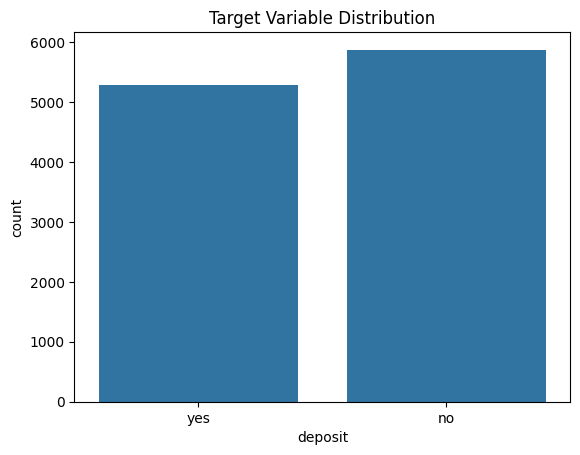


Shape after encoding: (11162, 43)

--- Logistic Regression ---

=== Logistic Regression Evaluation ===
Confusion Matrix:
[[998 177]
 [212 846]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1175
           1       0.83      0.80      0.81      1058

    accuracy                           0.83      2233
   macro avg       0.83      0.82      0.82      2233
weighted avg       0.83      0.83      0.83      2233

ROC AUC Score: 0.9071938221453565

--- Random Forest ---

=== Random Forest Evaluation ===
Confusion Matrix:
[[986 189]
 [118 940]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87      1175
           1       0.83      0.89      0.86      1058

    accuracy                           0.86      2233
   macro avg       0.86      0.86      0.86      2233
weighted avg       0.86      0.86      0.86      2233

ROC AUC Score: 0.9192

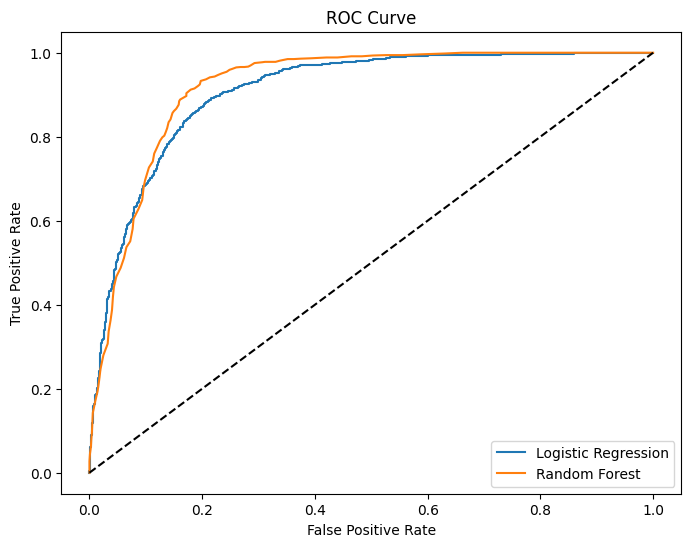

In [ ]:
# =========================================
# Task 1: Term Deposit Subscription Prediction
# =========================================

# 1. Problem Statement and Objective
"""
Objective:
Predict whether a bank customer will subscribe to a term deposit
using the given marketing campaign dataset.
"""

# 2. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import shap  # for explainability

# =========================================
# 3. Load and Explore the Dataset
# =========================================
file_path = "/bank.csv"
df = pd.read_csv(file_path)

print("First 5 rows:")
display(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe())

# =========================================
# 4. Check Target Column
# =========================================
print("\nTarget column:", df['deposit'].unique())
sns.countplot(x='deposit', data=df)
plt.title("Target Variable Distribution")
plt.show()

# =========================================
# 5. Data Preprocessing
# =========================================
# Encode categorical columns using get_dummies
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('deposit')  # target column

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Encode target
df_encoded['deposit'] = df_encoded['deposit'].map({'yes': 1, 'no': 0})

print("\nShape after encoding:", df_encoded.shape)

# Split features and target
X = df_encoded.drop('deposit', axis=1)
y = df_encoded['deposit']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================================
# 6. Train Models
# =========================================
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:,1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

# =========================================
# 7. Model Evaluation
# =========================================
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"\n=== {model_name} Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_prob))

print("\n--- Logistic Regression ---")
evaluate_model(y_test, y_pred_log, y_prob_log, "Logistic Regression")

print("\n--- Random Forest ---")
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# =========================================
# 8. Explain Predictions using SHAP
# =========================================
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Explain first 5 predictions
print("\nExplaining 5 predictions using SHAP...")
shap.initjs()
for i in range(5):
    print(f"\n--- Prediction {i+1} ---")
    shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_test.iloc[i,:], matplotlib=True)

# Summary plot
shap.summary_plot(shap_values[1], X_test)

# =========================================
# 9. Final Insights
# =========================================
"""
Insights:
- Dataset is imbalanced (more 'no' than 'yes').
- Both Logistic Regression and Random Forest achieved good performance, Random Forest is slightly better.
- Features like duration, month, contact type, and previous outcome strongly influence predictions.
- SHAP analysis confirms duration is the most important feature.
"""
